# 1D Gaussian DSM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


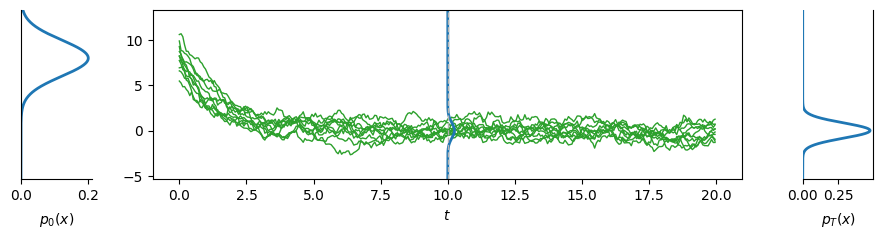

In [16]:
import Final_1DGaussian_SDEODE_ForeBaxk as ou
from Final_1DGaussian_SDEODE_ForeBaxk import *

beta=0.7
sigma=1.0
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

# 測試檔案內function可用
SDE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)

# DSM Loss
**Notation**

- $x_0$: original data;
- $p_0(x_0)$: data distribution of original data;
- $x$: noisy data (by perturbing the original data);
- $p(x \mid x_0)$: conditional (noisy) data distribution;
- $p_\sigma(x)$: (noisy) data distribution.

We also note that  
$$
p_\sigma(x) = \int_{\mathbb{R}^d} p(x \mid x_0)\, p_0(x_0)\, dx_0.
$$

The goal of denoising score matching is to find the **noisy score function**  
$$
S_\sigma(x; \theta) = \nabla_x \log p_\sigma(x).
$$

The DSM objective can be written as  
$$
L_{\text{DSM}}(\theta)
= \mathbb{E}_{x_0 \sim p_0(x_0)} \mathbb{E}_{x \sim p(x \mid x_0)}
\left[ \left\|\, S_\sigma(x; \theta) - \nabla_x \log p(x \mid x_0)\, \right\|^2 \right].
$$



一般來說在實務上會用Gaussian 作為data，也就是讓$x=x_0+\sigma\epsilon,\,\,\epsilon\sim\mathcal{N}(0,I)$。所以：
$$
\nabla_x \log p_\sigma(x|x_0)=-\frac{1}{\sigma^2}(x-x_0)=-\frac{1}{\sigma^2}\epsilon_{\sigma}.
$$
換言之，DSM的loss就可以被改寫為：
$$
L_{DSM}(\theta)= \mathbb{E}_{x_0\sim p_0(x_0)}\mathbb{E}_{x|x_0\sim p_\sigma(x|x_0)}\frac{1}{\sigma^2}\left\|\sigma S_\sigma(x_0+\sigma\epsilon;\theta)+\epsilon \right\|^2.
$$


## DSM code

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cpu")
## ---參數跟之前差不多
beta=0.7
sigma=1.0   ## OU SDE's noise level
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

In [36]:
## 解析mean/var
def mean_t(t):
    return np.exp(-beta*t)*mu1
def var_t(t):
    return np.exp(-2*beta*t)*(s1**2)+(sigma**2/(2*beta))*(1-np.exp(-2*beta*t))
def true_score_np(x,t):
    m=mean_t(t)
    v=var_t(t)
    return -(x-m)/v

In [37]:
class FourierEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        half_dim = dim
        freqs = torch.exp(
            -np.log(10000) * torch.arange(half_dim) / half_dim
        )
        self.freqs = freqs  # shape = (dim,)

    def forward(self, t):
        # t: (B,1)
        t = t.float()
        freqs = self.freqs.to(t.device)  # (dim,)
        x = t * freqs                    # (B, dim)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)  # (B, 2*dim)


In [46]:
def sample_xt_t(batch_size):
    # sample t as numpy array, shape = (B,1)
    t = np.random.uniform(0, T, (batch_size, 1)).astype(np.float32)

    # compute mean/var in numpy
    m = mean_t(t)      # numpy output
    v = var_t(t)

    # sample x_t from OU distribution
    x = m + np.sqrt(v) * np.random.randn(batch_size, 1)

    return x.astype(np.float32), t.astype(np.float32)


### 定義Score network : $S_\sigma(x; \theta)$

In [47]:
class ScoreNet(nn.Module):
    def __init__(self, hidden=128, num_layers=3, t_embed_dim=32):
        super().__init__()

        self.t_embed = FourierEmbedding(dim=t_embed_dim)
        t_out_dim = t_embed_dim * 2     # since output is sin/cos stack

        in_dim = 1 + t_out_dim          # x (1) + time embedding

        layers = [nn.Linear(in_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        t_emb = self.t_embed(t)         # shape = (B, t_out_dim)
        z = torch.cat([x, t_emb], dim=1)
        return self.net(z)

model=ScoreNet(hidden=128, num_layers=9, t_embed_dim=32).to(device)
#print(model)

### DSM loss + Training loop
**Goal:**
$$
S_{\sigma}(x;\theta)\approx-\frac{\epsilon}{\sigma_{dsm}}
$$

In [48]:
sigma_dsm=0.5
batch_size=2048
num_steps=5000
lr=5e-3
optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # lr = lr * 0.5
    patience=200,     # 若 200 steps 沒有改善就降低 lr
    verbose=True
)

def dsm_loss_step():
    # 1) sample(x_t,t) from true OU
    x_np, t_np = sample_xt_t(batch_size)
    x=torch.from_numpy(x_np).to (device)   #####<<<<<<<<<看一下為甚麼要那麼複雜
    t=torch.from_numpy(t_np).to (device)
    
    # 2) add DSM noise
    eps=torch.randn_like(x)
    x_tilde=x+sigma_dsm*eps

    # 3) predict score at noisy input
    s_hat=model(x_tilde,t)  ##(B,1)

    # 4) DSM target
    target = -eps / sigma_dsm
    loss=((s_hat-target)**2).mean()

    return loss

loss_history=[]
for step in range(1,num_steps+1):  ##從1到num_step的數值
    model.train()
    loss = dsm_loss_step()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step%500==0:  ### 每500步寫一個
        print(f"step {step:5d} | loss = {loss.item():6f}")



step   500 | loss = 3.133091
step  1000 | loss = 3.118362
step  1500 | loss = 3.094771
step  2000 | loss = 2.939129
step  2500 | loss = 3.048499
step  3000 | loss = 2.964322
step  3500 | loss = 3.156991
step  4000 | loss = 2.950323
step  4500 | loss = 2.965189
step  5000 | loss = 3.147359


<function matplotlib.pyplot.show(close=None, block=None)>

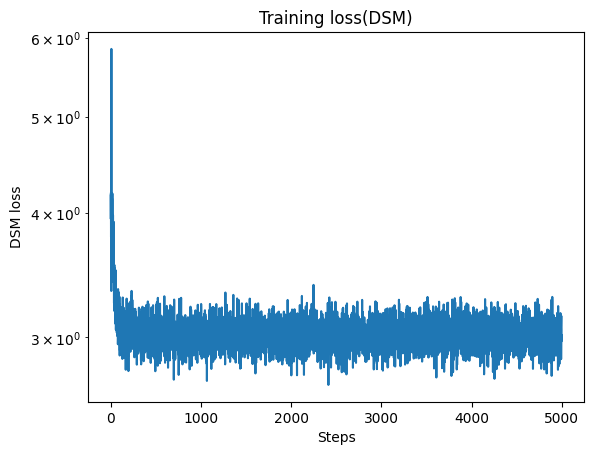

In [49]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("DSM loss")
plt.yscale("log")
plt.title("Training loss(DSM)")
plt.show

t=  0.0 | MSE(score) = 1.975882e-02
t=  2.0 | MSE(score) = 4.598504e-02
t=  5.0 | MSE(score) = 8.963425e-02
t= 10.0 | MSE(score) = 8.989065e-02
t= 15.0 | MSE(score) = 9.554460e-02
t= 20.0 | MSE(score) = 9.256335e-02


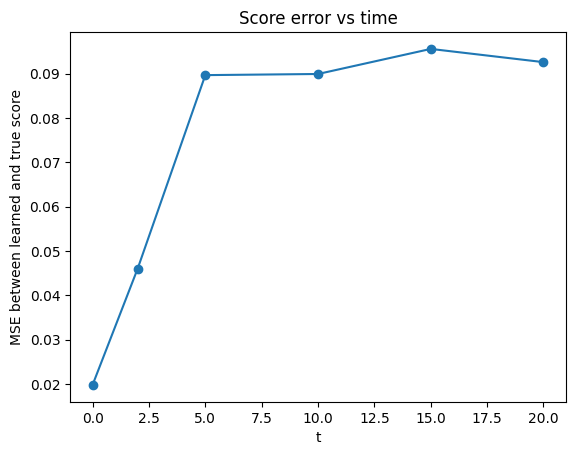

In [52]:
###  跟真實OU score 比較(MSE loss)
def eval_score_mse_at_t(t_eval, n_points=2000):
    # 固定 t_eval 抽一堆x_t
    t_arr = np.full((n_points, 1), t_eval, dtype=np.float32)
    m=mean_t(t_arr)
    v=var_t(t_arr)
    x_arr = m+np.sqrt(v)*np.random.randn(n_points, 1).astype(np.float32)

    # true score
    s_true=true_score_np(x_arr, t_arr)  ## (N,1)
    
    # Model score
    x=torch.from_numpy(x_arr).to(device)
    t=torch.from_numpy(t_arr).to(device)
    model.eval()
    with torch.no_grad():
        s_hat = model(x,t).cpu().numpy()

    mse=np.mean((s_hat-s_true)**2)
    
    return mse, x_arr, s_true, s_hat

t_list=[0.0, 2.0, 5.0, 10.0, 15.0, 20.0]
mses=[]
for t_eval in t_list:
    mse, _, _, _=eval_score_mse_at_t(t_eval)
    mses.append(mse)
    print(f"t= {t_eval:4.1f} | MSE(score) = {mse:.6e}")

plt.plot(t_list, mses, marker="o")
plt.xlabel("t")
plt.ylabel("MSE between learned and true score")
plt.title("Score error vs time")
plt.show()




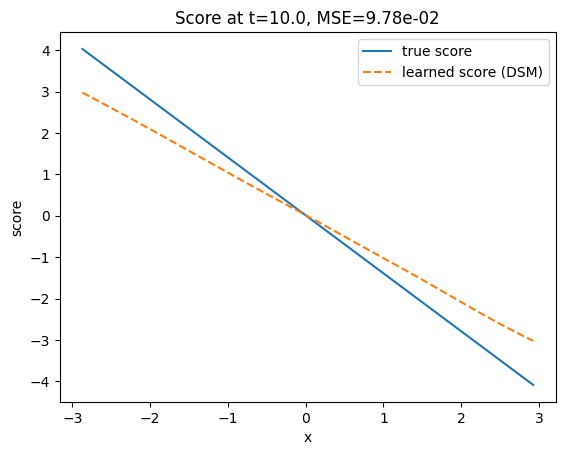

In [53]:
# 選一個時間，直接畫出 score(x,t) 的曲線
t_eval = 10.0

mse, x_arr, s_true, s_hat = eval_score_mse_at_t(t_eval)

order = np.argsort(x_arr[:,0])
x_sorted = x_arr[order,0]
s_true_sorted = s_true[order,0]
s_hat_sorted  = s_hat[order,0]

plt.plot(x_sorted, s_true_sorted, label="true score")
plt.plot(x_sorted, s_hat_sorted,  "--", label="learned score (DSM)")
plt.xlabel("x")
plt.ylabel("score")
plt.title(f"Score at t={t_eval}, MSE={mse:.2e}")
plt.legend()
plt.show()
